# Assignment 4: A GRU-pair model for SNLI with attention

In this assignment we'll build and train an attention-based model for SNLI based on the word-by-word attention with matching layer designed from [Wang and Jiang](https://arxiv.org/pdf/1512.08849v2.pdf). 


As in Lab5  we'll focus on  __Natural Language Inference__ (NLI) task. Recall that NLI consists in determining whether a natural language _hypothesis_ can justifiably be inferred from a natural language _premise_. Thus given a pair of  premise  and  hypothesis texts, the task is to classify them into three categories: _entailment_, _contradiction_, and _neutral_. The table below shows a few examples of premise/hypothesis along with the annotated labels (examples taken from [here](https://nlp.stanford.edu/pubs/snli_paper.pdf)).

The dataset we will use in this lab can be downloaded from [here](https://nlp.stanford.edu/projects/snli/) and it is a corpus comprised by The Stanford Natural Language Processing Group. Actually we are using a subset of the whole dataset. This is the same subset used in Lab5 so you can compare the results. 


| Premise                                                               | Category      | Hypothesis                                                         |   |   |
|:--------------------------------------------------------------------|:---------------|:--------------------------------------------------------------------|
| A man inspects the uniform of a figure in some East Asian country. | contradiction | The man is sleeping                                                |
| An older and younger man smiling.                                  | neutral       | Two men are smiling and laughing at the cats playing on the floor. |
| A black race car starts up in front of a crowd of people.          | contradiction | A man is driving down a lonely road.                               |
| A soccer game with multiple males playing.                         | entailment    | Some men are playing a sport.                                     |
| A smiling costumed woman is holding an umbrella.                   | neutral       | A happy woman in a fairy costume holds an umbrella.                |

----

## Attention Model
As stated above, the model will incorporate the basic __word-by-word attention__ + __matching layer__ design from [Wang and Jiang](https://arxiv.org/pdf/1512.08849v2.pdf), but it will use __GRUs__ instead of LSTMs, and it will use [Luong et al.](http://www.aclweb.org/anthology/D15-1166)'s 'general' bilinear attention scoring function. See below for the implementation details.

>>> ![](https://drive.google.com/uc?id=11Y9qwCUaTKV-CRxtbXindwxKNnVnn15a)


The paper proposes to use three LSTMs (GRU in our case) to 1) encode the steps in the premise ($H^{s}$),  2) encode the steps in hypothesis (e.g $h_{k}^{t}$) and 3) encode the matching steps ($h_{k}^{m}$). Please go to  [Wang and Jiang](https://arxiv.org/pdf/1512.08849v2.pdf) to understand the details of the architecture and the attention model. 





## Setup

You will need first to mount your Google Drive  folder and give access to the Notebook. Please run the following cell and follow the instructions.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In a similar way as in previous labs, we'll first load the data and inspect it. You should have you data in your drive under ```2019-2020_labs/data/snli``` (the data is the same the one that you can downloaded from [here](https://nlp.stanford.edu/projects/snli/) , but we get rid off stuff we do not need this lab).

You we'll need to mount your Drive folder first to access the data. This will require one-step authentication. Please when you run the cell below follow the instructions. Once you mount everything, make sure ```snli_home = 'drive/My Drive/Colab Notebooks/2019-2020_labs/data/snli/``` is correct path for your data.

The cells below upload the training, development and test files:

-  ```snli_1.0_train.jsonl```
- ```snli_1.0_dev.jsonl```
-  ```snli_1.0_test.jsonl```


In [0]:
snli_home = 'drive/My Drive/2019-2020_labs/data/snli'

import re
import random
import json

LABEL_MAP = {
    "entailment": 0,
    "neutral": 1,
    "contradiction": 2
}

def load_snli_data(path):
    data = []
    with open(path) as f:
        for line in f:
            loaded_example = json.loads(line)
            if loaded_example["gold_label"] not in LABEL_MAP:
                continue
            loaded_example["label"] = LABEL_MAP[loaded_example["gold_label"]]
            data.append(loaded_example)
        random.seed(1)
        random.shuffle(data)
    return data
     
training_set = load_snli_data(snli_home + '/snli_1.0_train.jsonl')
dev_set = load_snli_data(snli_home + '/snli_1.0_dev.jsonl')
test_set = load_snli_data(snli_home + '/snli_1.0_test.jsonl')

Next, we'll convert the data to index vectors in the same way that we've done for in-class exercises with RNN-based sentiment models. A few notes:

- We use a sequence length of only 10, which is short enough that we're truncating a large fraction of sentences.
- Tokenization is easy here because we're relying on the output of a parser (which does tokenization as part of parsing), just as with the SST corpus that we've been using until now. Note that we use the 'sentence1_binary_parse' field of each example rather than the human-readable 'sentence1'.
- We're using a moderately large vocabulary of about 36k words.

In [0]:
SEQ_LEN = 10

import collections
import numpy as np

def sentences_to_padded_index_sequences(datasets):
    '''Annotates datasets with feature vectors.'''
    
    PADDING = "<PAD>"
    UNKNOWN = "<UNK>"
    
    # Extract vocabulary
    def tokenize(string):
        string = re.sub(r'\(|\)', '', string)
        return string.lower().split()
    
    word_counter = collections.Counter()
    for example in datasets[0]:
        word_counter.update(tokenize(example['sentence1_binary_parse']))
        word_counter.update(tokenize(example['sentence2_binary_parse']))
        
    vocabulary = set([word for word in word_counter])
    vocabulary = list(vocabulary)
    vocabulary = [PADDING, UNKNOWN] + vocabulary
        
    word_indices = dict(zip(vocabulary, range(len(vocabulary))))
    indices_to_words = {v: k for k, v in word_indices.items()}
        
    for i, dataset in enumerate(datasets):
        for example in dataset:
            for sentence in ['sentence1_binary_parse', 'sentence2_binary_parse']:
                example[sentence + '_index_sequence'] = np.zeros((SEQ_LEN), dtype=np.int32)

                token_sequence = tokenize(example[sentence])
                padding = SEQ_LEN - len(token_sequence)

                for i in range(SEQ_LEN):
                    if i >= padding:
                        if token_sequence[i - padding] in word_indices:
                            index = word_indices[token_sequence[i - padding]]
                        else:
                            index = word_indices[UNKNOWN]
                    else:
                        index = word_indices[PADDING]
                    example[sentence + '_index_sequence'][i] = index
    return indices_to_words, word_indices
    
indices_to_words, word_indices = sentences_to_padded_index_sequences([training_set, dev_set, test_set])

In [0]:
print (training_set[6])
print (len(word_indices))

{'annotator_labels': ['entailment'], 'captionID': '5574382134.jpg#2', 'gold_label': 'entailment', 'pairID': '5574382134.jpg#2r1e', 'sentence1': 'A little black girl is holding rocks in her hand.', 'sentence1_binary_parse': '( ( A ( little ( black girl ) ) ) ( ( is ( ( holding rocks ) ( in ( her hand ) ) ) ) . ) )', 'sentence1_parse': '(ROOT (S (NP (DT A) (JJ little) (JJ black) (NN girl)) (VP (VBZ is) (NP (NP (VBG holding) (NNS rocks)) (PP (IN in) (NP (PRP$ her) (NN hand))))) (. .)))', 'sentence2': 'A miss holds pieces of nature.', 'sentence2_binary_parse': '( ( A miss ) ( ( holds ( pieces ( of nature ) ) ) . ) )', 'sentence2_parse': '(ROOT (S (NP (DT A) (NN miss)) (VP (VBZ holds) (NP (NP (NNS pieces)) (PP (IN of) (NP (NN nature))))) (. .)))', 'label': 0, 'sentence1_binary_parse_index_sequence': array([29498, 16247,  6720, 17616,  2181,  5944,  8855,  3984, 23664,
       28251], dtype=int32), 'sentence2_binary_parse_index_sequence': array([    0,     0,     0,  1591, 31692, 26241, 26757

Now we load GloVe. You'll need the same file that you used for the in-class exercise on word embeddings. Make sure ```glove_home = 'drive/My Drive/Colab Notebooks/2018-2019_labs/data/embeddings/``` is correct path for your word embeddings file.

In [0]:
glove_home = 'drive/My Drive/2019-2020_labs/data/embeddings'
words_to_load = 50000

with open(glove_home + '/glove.6B.50d.txt') as f:
    loaded_embeddings = np.zeros((len(word_indices), 50), dtype='float32')
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        
        s = line.split()
        if s[0] in word_indices:
            loaded_embeddings[word_indices[s[0]], :] = np.asarray(s[1:])

Now we set up an evaluation function as before.

In [0]:
def evaluate_classifier(classifier, eval_set):
    correct = 0
    hypotheses = classifier(eval_set)
    for i, example in enumerate(eval_set):
        hypothesis = hypotheses[i]
        if hypothesis == example['label']:
            correct += 1        
    return correct / float(len(eval_set))

## Assignment Part

Expand the below starter code to build a working attention-based NLI model. The model should feature the following:

- 50D word embeddings initialized with GloVe and trained. (Using self.E should provide this.)
- Three GRUs (with two different sets of parameters): a premise encoder, a hypothesis encoder (sharing the same parameters), and matching GRU, taking the place of [Wang and Jiang](https://arxiv.org/pdf/1512.08849v2.pdf)'s mLSTM, with its own parameters. There shouldn't be a connection between the premise and hypothesis GRUs: the starting hidden state for each of the three GRUs should be zeros.
- Word-by-word attention using [Luong et al.](http://www.aclweb.org/anthology/D15-1166)'s 'general' (bilinear) scoring function.
- A three-way softmax classifier whose input is the final hidden state of the matching RNN.

You are welcome to use code from solutions to past exercises. As ever, do not use any other __pre-written code__ or __TF functions__ that are specific to RNNs or attention. You can reuse the code of previous labs (specially, take advange of the code provided in the solution of Lab5).


As in class, the below line may give you a warning. It should be safe to ignore.

## Guide for Completing the Assigment

As the assignement is quite demanding and  due to stundets do no have too m , We provide some instructions to complete correctly the assignment that can be useful. This set of hints/explanaitions is a guide for one type of solution, but it is not obligatory to follow these instruction. So feel free to come up with another way of implementing the model. 


1.   **Read the papers**. Thoroughly read the paper that describes the model with word-by-word+matching layer: [Wang and Jiang](https://arxiv.org/pdf/1512.08849v2.pdf). In addition, it should be very helpful to understand [Rocktäschel's](https://arxiv.org/pdf/1509.06664v4.pdf) model, as the model to be implemented realies on this one. Optionally,  you read [Luong et al.](http://www.aclweb.org/anthology/D15-1166) to know more about the general 'bilinear'  attention score function.

2.   **Attention scoring function**. In this implementation, we are going to change the attention scoring function shown in equation 6 ([Wang and Jiang](https://arxiv.org/pdf/1512.08849v2.pdf)). Instead we'll use  [Luong et al.](http://www.aclweb.org/anthology/D15-1166) general 'bilinear' attention scoring.

>Following same notation of [Wang and Jiang](https://arxiv.org/pdf/1512.08849v2.pdf) equation 6 is defined as follow:

>> $ e_{kj} = \mathbf{w^{e}} \cdot tanh (\mathbf{W^{s}h^{s}_{j}} +  \mathbf{W^{t}h^{t}_{k}} +  \mathbf{W^{m}h^{m}_{k-1}} )$

> You should substitute by this:

>> $e_{kj} = [ \mathbf{h^{t}_{k}}; \mathbf{h^{m}_{k-1}} ] \ \mathbf{W} \ \mathbf{h^{s}_{j}}$

> Note that in Lab5 we were learning attention parameter using wider set of matrices (e.g. $\mathbf{W^{y}}, \mathbf{W^{h}}, \mathbf{w}, \ldots$). In this case we considerably reduce the complexity of the attention scoring function as we are using only one parameter matrix (note that in this case $\mathbf{W}$ is not symmetric).

3. **Premise encoder** (```premise_step```). Take a look at the solution of Lab5, it should be very simillar, if not the same. 

4. **Hypothesis encoder** (```hypothesis_step```). This is the most complicated part, as you need to implement the attention mechanism as well. Apart fron the use of the two GRUs (the encoder for the premise and hypothesis, and the matching GRU), you need to implement the equations 2, 3, and the new scoring function defined above.

> Think of what you need to compute the hypothesis step and what should return the functions. For this you will need to revise the equations that defined the attention model. 

5. **Unroll the premise**. As you are reading the word sequence of the premise and storing the state of each time step (```premise_step```), it is good idea to calculate a part of the function of the bilinear attention scoring of each time step: $\mathbf{W \ h_{j}^{s}}$ (```projected_premise_step```).

6. **Unroll the hypothesis**. As similarly done in Lab5, you need to run over the hypothesis sequence (do not condition with last output of the premise!) updating the state of the GRU and keep tha last one. 
You should get attention weights of each time step to plot them.

proposed solution consists on the following hypothesis unrolling schema:

>>> ![](https://drive.google.com/uc?id=12dzKnjEJPCA61Er5KnqiAVri2mj2gBt9)


For a better understand of the solution provided :

>>> ![](https://drive.google.com/uc?id=11Y9qwCUaTKV-CRxtbXindwxKNnVnn15a)




In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1)

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

TensorFlow 2.x selected.


'2.1.0'

In [0]:
class RNNEntailmentClassifier:
    def __init__(self, vocab_size, sequence_length):
        # Define the hyperparameters
        self.training_epochs = 1  # How long to train for - chosen to fit within class time
        self.display_epoch_freq = 1  # How often to print cost (in epochs)
        self.display_step_freq = 250  # How often to test (in steps)
        self.dim = 10  # The dimension of the hidden state of each RNN
        self.embedding_dim = 50  # The dimension of the learned word embeddings
        self.batch_size = 64  # Somewhat arbitrary - can be tuned, but often tune for speed, not accuracy
        self.vocab_size = vocab_size  # Defined by the file reader above
        self.sequence_length = sequence_length  # Defined by the file reader above
        self.step = 1
        self.epoch = 0 
        # Define the parameters
        self.trainable_variables = []
        self.E = tf.Variable(loaded_embeddings, trainable=False)
        self.trainable_variables.append(self.E)
        # TODO: Define the parameters of the GRUs
        #  - Note that we need to learn two GRUs: 
        #  - Use Figure above to understand how you can organize you GRU models.
        # params for encoding (premise) , decoding (hypothesis) and attention Weights (attention) GRU
        self.W_rnn = {}
        self.W_r = {}
        self.W_z = {}
        self.b_rnn = {}
        self.b_r = {}
        self.b_z = {} 

        # - You can re-use part of you code in lab5
        for self.name in ['p', 'h','m']:
            # but you need to set different dimensionality to each GRU...
            if self.name == 'm':
              # 2) for maching GRU. Hint: What is the dimensionality of input??
              # input 4m the atention weigths??
              in_dim = 2*self.dim
              out_dim = 0
              # in_dim = 2*self.dim
            elif self.name == 'p':
              # 2) for maching GRU. Hint: What is the dimensionality of input??
              # input 4m the atention weigths??
              out_dim = self.dim
              in_dim = self.embedding_dim + self.dim
              # in_dim = 2*self.dim
            else:
              # 1) for encoding premise and hypothesis
              in_dim = self.embedding_dim
              out_dim = 0
            # init GRU params ... check lab 5

            self.W_rnn[self.name] = tf.Variable(tf.random.normal([in_dim + self.dim, out_dim + self.dim], stddev=0.1))
            self.b_rnn[self.name] = tf.Variable(tf.random.normal([self.dim+out_dim], stddev=0.1))
            self.trainable_variables.append(self.W_rnn[self.name])
            self.trainable_variables.append(self.b_rnn[self.name])
            
            self.W_r[self.name] = tf.Variable(tf.random.normal([in_dim + self.dim, out_dim + self.dim], stddev=0.1))
            self.b_r[self.name] = tf.Variable(tf.random.normal([self.dim+out_dim], stddev=0.1))
            self.trainable_variables.append(self.W_r[self.name])
            self.trainable_variables.append(self.b_r[self.name])
            
            self.W_z[self.name] = tf.Variable(tf.random.normal([in_dim + self.dim, out_dim + self.dim], stddev=0.1))
            self.b_z[self.name] = tf.Variable(tf.random.normal([self.dim+out_dim], stddev=0.1))
            self.trainable_variables.append(self.W_z[self.name])
            self.trainable_variables.append(self.b_z[self.name])           
        
        # TODO: Define the attention parameters.
        #  - Attention parameters: You need to define just one variable that learns matching 
        #    premise and hypothesis sequences.
            self.attn = tf.Variable(tf.random.normal([2*self.dim, 2*self.dim], stddev=0.1))
        #  - Attention score is defined in eq. 8 in Luong et al. (general score)
        #  - This simplify eq.6 in Wang and Jiang for the attention score.
        #    self.score = tf.Variable(tf.random.normal([self.dim , self.dim], stddev=0.1))
        #  - Hint: What are the dimensionality of vectors of both side in the equation? 
        
        # TODO: Define the paremeters for the classification layer (as in Lab5).
        self.w_cl = tf.Variable(tf.random.normal([self.dim , 3], stddev=0.1))
        self.b_cl = tf.Variable(tf.random.normal([3], stddev=0.1))
          
    # Define the model: Complete the functions 
    # paper = REASONING ABOUTENTAILMENT WITHNEURALATTENTION (Rocktäschel's)
    def model(self,premise_x,hypothesis_x):
        # define the GRU function (Hint: check lab 5)
        def gru(emb, h_prev, name):
          emb_h_prev = tf.concat([emb, h_prev], 1, name=name + '_emb_h_prev')
          z = tf.nn.sigmoid(tf.matmul(emb_h_prev, self.W_z[name])  + self.b_z[name], name=name + '_z')
          r = tf.nn.sigmoid(tf.matmul(emb_h_prev, self.W_r[name])  + self.b_r[name], name=name + '_r')
          emb_r_h_prev = tf.concat([emb, r * h_prev], 1, name=name + '_emb_r_h_prev')
          h_tilde = tf.nn.tanh(tf.matmul(emb_r_h_prev, self.W_rnn[name])  + self.b_rnn[name], name=name + '_h_tilde')
          h = (1. - z) * h_prev + z * h_tilde
          return h
        def premise_step(x, h_prev):
          # - Note that attention mechanism is inside premise step (local calculation).
          emb = tf.nn.embedding_lookup(self.E, x)
          h_current = gru(emb, h_prev, 'p')
          # following attention based models (light ver.)
          projected_premise = tf.matmul(h_current , self.attn) # local attention (W * Hs_j) 
          return h_current, projected_premise
        def hypothesis_step(x, h_prev, h_attn_k_prev, premise_steps, projected_premise_steps):
          # - Note that attention mechanism is inside hypothesis step (global calculation).
          # the attention is handled every step on hattn_k
          # calculate current layer representation ht_k 
          emb = tf.nn.embedding_lookup(self.E, x)
          ht_k = gru(emb, h_prev, 'h')     
          # paper = Effective Approaches to Attention-based Neural Machine Translation
          # calculate current attention representation h_m (global attention) 
          # Equation (6) but differently handled  
          h_current_prev_attn = tf.concat([ht_k, h_attn_k_prev] , -1)
          # Equation (explained above)
          e_k = h_current_prev_attn * projected_premise_steps
          # Equation (3)
          alfas = tf.nn.softmax(e_k)
          # (premise_max_len, batch_size)
          # Equation (2)
          attn_weights = alfas * premise_steps
          h_attn_k = sum([weight for weight in attn_weights])
          # paper = Learning Natural Language Inference with LSTM (Wang and Jiang) 
          # Equation (8)
          h_m = gru(h_attn_k, h_attn_k_prev, 'm') 
          return h_m, ht_k   
        # Split up the inputs into individual tensors
        self.x_premise_slices = tf.split(premise_x, self.sequence_length, 1)
        self.x_hypothesis_slices = tf.split(hypothesis_x, self.sequence_length, 1)  
        # Unroll the first RNN (Premise). (Hint: check lab 5)
        self.prem_zero = tf.zeros(tf.stack([tf.shape(premise_x)[0], 2*self.dim]))
        # Unroll the first RNN
        premise_h_prev = self.prem_zero
        premise_steps = [] # Y input into attention (Hs)
        projected_premise_steps = []
        for t in range(self.sequence_length):
            x_t = tf.reshape(self.x_premise_slices[t], [-1])
            # 1.calculate the state of every premise step.
            # TODO 2.calculate a part of the function of the bilinear attention scoring of each time step: projected_premise_step
            premise_h_prev, projected_premise = premise_step(x_t, premise_h_prev)
            # keep all the premise steps and projected premise steps
            premise_steps.append(premise_h_prev)
            projected_premise_steps.append(projected_premise)       
        # Unroll the second RNN (Hypothesis). (Hint: check lab 5)
        self.hyp_zero = tf.zeros(tf.stack([tf.shape(hypothesis_x)[0], self.dim]))
        self.h_prev_attn_weights = tf.zeros(tf.stack([tf.shape(hypothesis_x)[0], self.dim])) # which is the shape of attention word 2 word ??  
        # re-init because really h_prev_attn_weights is learning (word2word), we extract the result from there
        h_prev_hypothesis =  self.hyp_zero
        h_prev_attn_weights = self.h_prev_attn_weights
        # print("attention initial shape {}".format(tf.shape(h_prev_attn_weights)))
        attn_weights_steps = []
        for t in range(self.sequence_length):
            x_t = tf.reshape(self.x_hypothesis_slices[t], [-1])
            # unroll step decoder 
            # 1. encode the hypothesis steps with the attention.
            h_prev_attn_weights, h_prev_hypothesis = hypothesis_step(x_t, h_prev_hypothesis, h_prev_attn_weights, premise_steps, projected_premise_steps)   
            attn_weights_steps.append(h_prev_attn_weights)
            # 2. keep the attention weights of each step.
        logits = tf.matmul(h_prev_attn_weights, self.w_cl) + self.b_cl # compute logits for classification (3 classes) 
        attn = tf.stack(attn_weights_steps, 1) # stack weights for plotting functions (example_len, sequence_len, dim)
        # we provide logits as prediction function (over last attn_step) and attn_steps as attention word2word for each premise | hypothesis 
        return logits, attn
        
    def train(self, training_data, dev_data):
        def get_minibatch(dataset, start_index, end_index):
            indices = range(start_index, end_index)
            premise_vectors = np.vstack([dataset[i]['sentence1_binary_parse_index_sequence'] for i in indices])
            hypothesis_vectors = np.vstack([dataset[i]['sentence2_binary_parse_index_sequence'] for i in indices])
            labels = [dataset[i]['label'] for i in indices]
            return premise_vectors, hypothesis_vectors, labels

        print('Training.')

        # Training cycle
        for _ in range(self.training_epochs):
            random.shuffle(training_data)
            avg_cost = 0.
            total_batch = int(len(training_data) / self.batch_size)
            
            # Loop over all batches in epoch
            for i in range(total_batch):
                # Assemble a minibatch of the next B examples
                minibatch_premise_vectors, minibatch_hypothesis_vectors, minibatch_labels = get_minibatch(
                    training_data, self.batch_size * i, self.batch_size * (i + 1))

                # Run the optimizer to take a gradient step, and also fetch the value of the 
                # cost function for logging
                with tf.GradientTape() as tape:
                  logits,_ = self.model(minibatch_premise_vectors,minibatch_hypothesis_vectors)
                  # Define the cost function (here, the softmax exp and sum are built in)
                  total_cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=minibatch_labels))

                # This  performs the main SGD update equation with gradient clipping
                optimizer_obj = tf.optimizers.Adam()
                gradients = tape.gradient(total_cost, self.trainable_variables)
                gvs = zip(gradients, self.trainable_variables)
                capped_gvs = [(tf.clip_by_norm(grad, 5.0), var) for grad, var in gvs if grad is not None]
                optimizer = optimizer_obj.apply_gradients(capped_gvs)

                if self.step % self.display_step_freq == 0:
                    print("Step:", self.step, "Dev acc:", evaluate_classifier(self.classify, dev_data[0:1000]), \
                        "Train acc:", evaluate_classifier(self.classify, training_data[0:1000])) 
                                  
                self.step += 1
                avg_cost += total_cost / (total_batch * self.batch_size)
                                
            # Display some statistics about the step
            # Evaluating only one batch worth of data -- simplifies implementation slightly
            if self.epoch % self.display_epoch_freq == 0:
                tf.print("Epoch:", (self.epoch + 1), "Cost:", avg_cost) 
            self.epoch += 1
    
    def classify(self, examples):
        # This classifies a list of examples
        premise_vectors = np.vstack([example['sentence1_binary_parse_index_sequence'] for example in examples])
        hypothesis_vectors = np.vstack([example['sentence2_binary_parse_index_sequence'] for example in examples])
        logits,_ = self.model(premise_vectors,hypothesis_vectors)
        return np.argmax(logits, axis=1)

    def get_attn(self, examples):
        premise_vectors = np.vstack([example['sentence1_binary_parse_index_sequence'] for example in examples])
        hypothesis_vectors = np.vstack([example['sentence2_binary_parse_index_sequence'] for example in examples])
        _,attn_weights = self.model(premise_vectors,hypothesis_vectors)
        # target weights matrix
        return np.reshape(attn_weights, [len(examples), 10, 10])
        
    def plot_attn(self, examples):
        attn_weights = self.get_attn(examples)

        for i in range(len(examples)):    
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.matshow(attn_weights[i,:,:], vmin=0., vmax=1., cmap=plt.cm.inferno)

            premise_tokens = [indices_to_words[index] for index in examples[i]['sentence1_binary_parse_index_sequence']]
            hypothesis_tokens = [indices_to_words[index] for index in examples[i]['sentence2_binary_parse_index_sequence']]

            ax.set_yticklabels(premise_tokens)
            ax.set_xticklabels(hypothesis_tokens, rotation=45)

            plt.xticks(np.arange(0, 10, 1.0))
            plt.yticks(np.arange(0, 10, 1.0))

This creates a classifier and initializes it. Note that starting and stopping training will not re-initialize the model.

In [0]:
classifier = RNNEntailmentClassifier(len(word_indices), SEQ_LEN)

Running this line tests that you've successfully avoided a common error in implementing attention: mixing up dimensions in a way that allows information about one example in a batch to impact the results for other examples. It should do nothing if the model behaves correctly, and will throw an error otherwise.

In [0]:
assert (classifier.get_attn(training_set[0:2])[0, :, :] == \
        classifier.get_attn(training_set[0:3])[0, :, :]).all(), \
       'Warning: There is cross-example information flow.'

Run the model below. Your goal is dev set performance above 72-74% at at least a few steps within the first 30 epochs. This may require running your model overnight, though it won't necessarily require running for all 30 epochs. Since a single epoch can take a long time with this model, you'll see accuracy results every 250 steps rather than every epoch.

In [0]:
classifier.train(training_set, dev_set) # 1 epochs computed because is large ...

Training.
Step: 250 Dev acc: 0.338 Train acc: 0.328
Step: 500 Dev acc: 0.459 Train acc: 0.421
Step: 750 Dev acc: 0.476 Train acc: 0.446
Step: 1000 Dev acc: 0.465 Train acc: 0.449
Step: 1250 Dev acc: 0.475 Train acc: 0.463
Step: 1500 Dev acc: 0.486 Train acc: 0.461
Step: 1750 Dev acc: 0.489 Train acc: 0.482
Step: 2000 Dev acc: 0.511 Train acc: 0.516
Step: 2250 Dev acc: 0.492 Train acc: 0.507
Step: 2500 Dev acc: 0.51 Train acc: 0.52
Step: 2750 Dev acc: 0.516 Train acc: 0.52
Step: 3000 Dev acc: 0.513 Train acc: 0.523
Step: 3250 Dev acc: 0.538 Train acc: 0.534
Step: 3500 Dev acc: 0.534 Train acc: 0.53
Step: 3750 Dev acc: 0.522 Train acc: 0.519
Step: 4000 Dev acc: 0.526 Train acc: 0.518
Step: 4250 Dev acc: 0.531 Train acc: 0.544
Step: 4500 Dev acc: 0.529 Train acc: 0.545
Step: 4750 Dev acc: 0.521 Train acc: 0.549
Step: 5000 Dev acc: 0.53 Train acc: 0.547
Step: 5250 Dev acc: 0.536 Train acc: 0.545
Step: 5500 Dev acc: 0.543 Train acc: 0.546
Step: 5750 Dev acc: 0.547 Train acc: 0.556
Step: 600

This will print some visualizations for the first ten training examples. It should be useful in the questions below.

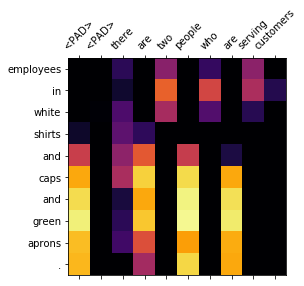

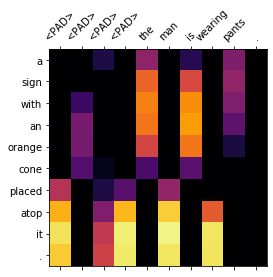

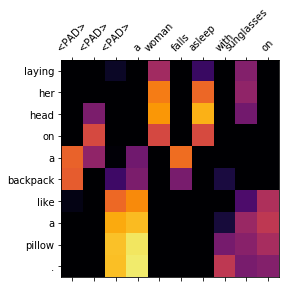

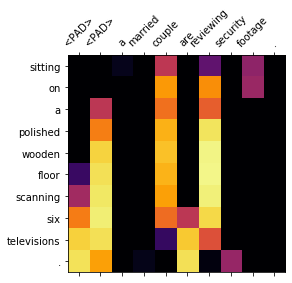

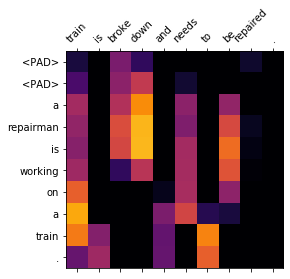

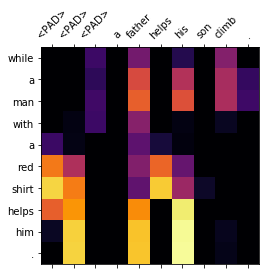

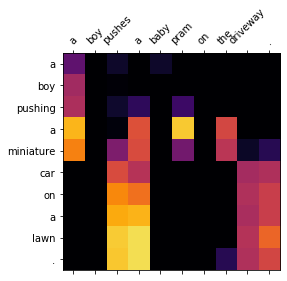

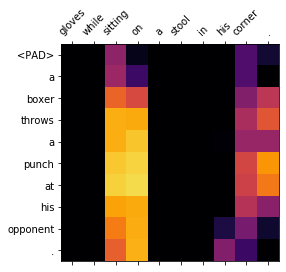

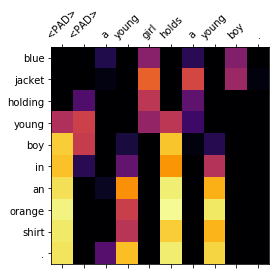

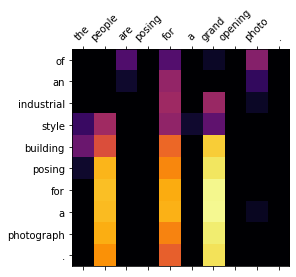

In [0]:
classifier.plot_attn(training_set[0:10])

# Team members: 
Edgar Andrés

Mohammed Yassin

Xaidé Caceres

Radostina Peteva

# Consultancy

Xiao Xu

# Atribution:
Adapted by Oier Lopez de Lacalle and Olatz Perez de Viñaspre, based on a notebook by Sam Bowman at NYU